# Stock market trends and Value at Risk

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to the use of [SciPy](https://www.scipy.org/) library's support for fitting probability distributions, and the Panda library's support for manipulating stock market data. See the [accompanying lecture slides](https://risk-engineering.org/VaR/) for background on the use of Value at Risk (VaR) as a financial risk metric. 

**Warning**: the analysis given here is pedagogical in nature and is not suitable for investment purposes!

In [43]:
# Note: you may need to install the pandas_datareader package, using a command such as 
# 
#    pip install pandas-datareader
import numpy
import scipy.stats
import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas import DataFrame
%matplotlib inline
%config InlineBackend.figure_formats=['png']

## Stock market returns and volatility

Let's download some stock market data for Microsoft (stock market ticker is `MSFT`) for the year 2013 and plot its evolution over time.

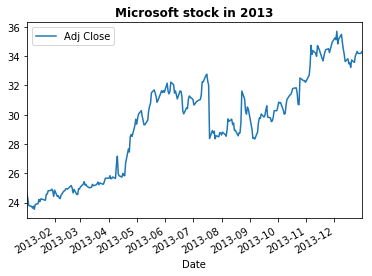

In [44]:
start = datetime.datetime(2013, 1, 1)
end   = datetime.datetime(2014, 1, 1)
MSFT = web.DataReader("MSFT", "yahoo", start, end)
MSFT.plot(y="Adj Close")
plt.title(u"Microsoft stock in 2013", weight='bold');

For risk analysis we are more interested in daily changes than in the absolute value of the stock, so we plot the daily returns on the stock.

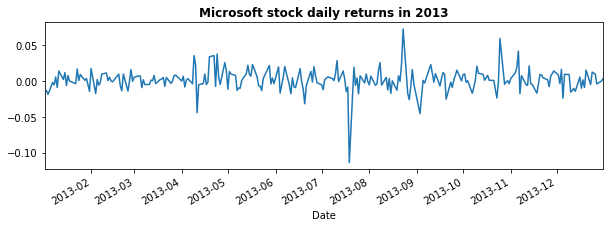

In [45]:
fig = plt.figure()
fig.set_size_inches(10,3)
MSFT["Adj Close"].pct_change().plot()
plt.title(u"Microsoft stock daily returns in 2013", weight='bold');

0.015604551776286254

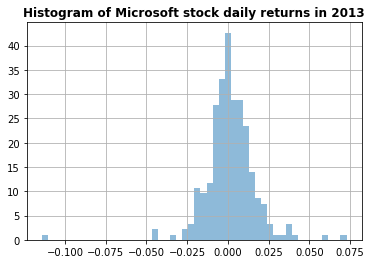

In [46]:
MSFT["Adj Close"].pct_change().hist(bins=50, normed=True, histtype='stepfilled', alpha=0.5)
plt.title(u"Histogram of Microsoft stock daily returns in 2013", weight='bold')
MSFT["Adj Close"].pct_change().std()

Let's see whether the daily returns are better represented by a normal distribution or by a Student-t distribution.

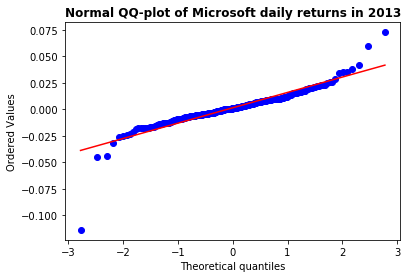

In [47]:
Q = MSFT["Adj Close"].pct_change().dropna().as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot of Microsoft daily returns in 2013", weight="bold");

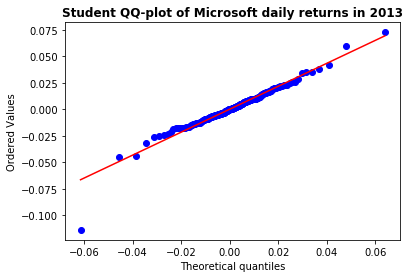

In [48]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot of Microsoft daily returns in 2013", weight="bold");

Student's t distribution does seem to fit better (look in particular at the tails of the distribution).

## Value at Risk using the historical bootstrap method

Method: we calculate **empirical quantiles** from a histogram of daily returns. Let's do that for the returns of Halliburton (stock market ticker `HAL`) over 2010--2014 (in reality, you would look at a longer time horizon, and give more weighting to recent activity than to activity several years ago).

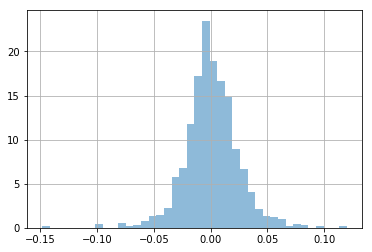

In [49]:
start = datetime.datetime(2010, 1, 1)
end   = datetime.datetime(2014, 1, 1)
stock = web.DataReader("HAL", "yahoo", start, end)
returns = stock["Close"].pct_change().dropna()
mean = returns.mean()
sigma = returns.std()
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);

In [50]:
returns.quantile(0.05)

-0.03413513746572812

The 0.05 empirical quantile of daily returns is at -0.034. That means that with 95% confidence, our worst daily loss will not exceed 3.4%. If we have a 1M€ investment, our one-day 5% VaR is 0.034 * 1M€ = 34 k€.

**Exercise**: estimate the one-day 1% VaR for the same stock using the historical bootstrap method.

## Value at Risk using the variance-covariance method

Method: calculate analytic quantiles by curve fitting to historical data. Here, we use Student's t distribution (we checked above that it represents daily returns relatively well).

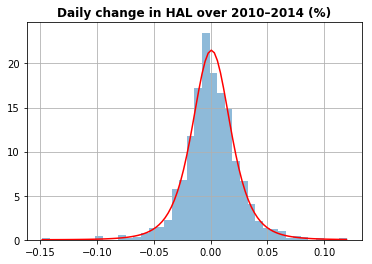

In [51]:
support = numpy.linspace(returns.min(), returns.max(), 100)
returns.hist(bins=40, normed=True, histtype='stepfilled', alpha=0.5);
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.title(u"Daily change in HAL over 2010–2014 (%)", weight='bold');

In [52]:
scipy.stats.norm.ppf(0.05, mean, sigma)

-0.038383332571956787

Our analytic 0.05 quantile is at -0.0384, so with 95% confidence, our worst daily loss will not exceed 3.84%. For a 1M€ investment, one-day Value at Risk is 0.0384 * 1M€ = 38k€.

**Exercise**: estimate the one-day Value at Risk at 1% confidence level for 1M€ invested in Apple stock (ticker is `AAPL`). 

## Value at Risk using the Monte Carlo method

**Method**: run many trials with random market conditions, calculating portfolio loss for each trial. Use the aggregated trial data to establish a profile of the porfolio's risk characteristics. See the slides associated with this notebook for details.

**Hypothesis**: stock market evolution can be simulated by geometric Brownian motion (this is a rough hypothesis; see the literature on stochastic methods in finance for more sophisticated, and more realistic, models, such as jump diffusion).

We start by defining some parameters of the geometric Brownian motion.

In [53]:
days = 300   # time horizon
dt = 1/float(days)
sigma = 0.04 # volatility
mu = 0.05  # drift (average growth rate)

This function simulates one stock market evolution, and returns the price evolution as an array. It simulates geometric Brownian motion using random numbers drawn from a normal distribution (see accompanying slides).

In [54]:
def random_walk(startprice):
    price = numpy.zeros(days)
    shock = numpy.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = numpy.random.normal(loc=mu * dt, scale=sigma * numpy.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return price

Let's simulate 30 random walks, starting from an initial stock price of 10€, for a duration of 300 days.

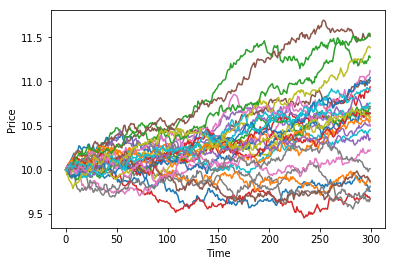

In [55]:
for run in range(30):
    plt.plot(random_walk(10.0))
plt.xlabel("Time")
plt.ylabel("Price");

Final price is spread out between 9.5€ (our portfolio has lost value) to almost 12€. The expectation (mean outcome) is a profit; this is due to the fact that the drift in our random walk (parameter mu) is positive.

Now let's run a big Monte Carlo simulation of random walks of this type, to obtain the probability distribution of the final price, and obtain quantile measures for the Value at Risk estimation. This will take a little time to run (decrease variable `runs` if you want faster, but less representative, results).

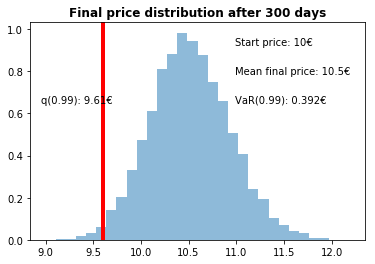

In [56]:
runs = 10000
simulations = numpy.zeros(runs)
for run in range(runs):
    simulations[run] = random_walk(10.0)[days-1]
q = numpy.percentile(simulations, 1)
plt.hist(simulations, normed=True, bins=30, histtype='stepfilled', alpha=0.5)
plt.figtext(0.6, 0.8, u"Start price: 10€")
plt.figtext(0.6, 0.7, u"Mean final price: {:.3}€".format(simulations.mean()))
plt.figtext(0.6, 0.6, u"VaR(0.99): {:.3}€".format(10 - q))
plt.figtext(0.15, 0.6, u"q(0.99): {:.3}€".format(q))
plt.axvline(x=q, linewidth=4, color='r')
plt.title(u"Final price distribution after {} days".format(days), weight='bold');

We have looked at the 1% empirical quantile of the final price distribution to estimate the Value at Risk, which is 0.427€ for a 10€ investment.

## Correlation between stocks

In [57]:
start = datetime.datetime(2005, 1, 1)
end   = datetime.datetime(2010, 1, 1)
CAC = web.DataReader("^FCHI", "yahoo", start, end)
DAX = web.DataReader("^GDAXI", "yahoo", start, end)
HSI = web.DataReader("^HSI", "yahoo", start, end)
AORD = web.DataReader("^AORD", "yahoo", start, end)

df = DataFrame({ 'CAC': CAC["Close"].pct_change(),
                 'DAX': DAX["Close"].pct_change(),
                 'HSI': HSI["Close"].pct_change(),
                 'AORD': AORD["Close"].pct_change() })
dfna = df.dropna()

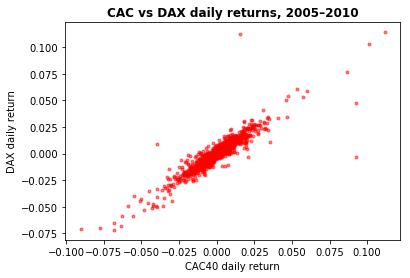

In [58]:
plt.plot(dfna["CAC"], dfna["DAX"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"DAX daily return")
plt.title(u"CAC vs DAX daily returns, 2005–2010", weight='bold');

In [59]:
scipy.stats.pearsonr(dfna["CAC"], dfna["DAX"])

(0.91762819023234377, 0.0)

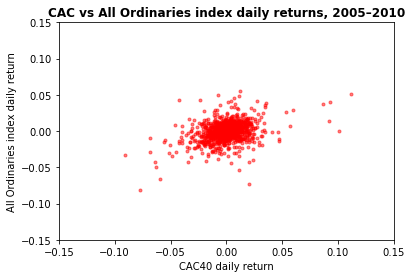

In [60]:
plt.plot(dfna["CAC"], dfna["AORD"], 'r.', alpha=0.5)
plt.xlabel(u"CAC40 daily return")
plt.ylabel(u"All Ordinaries index daily return")
# ensure square aspect ratio
plt.axes().set_xlim(-0.15, 0.15)
plt.axes().set_ylim(-0.15, 0.15)
plt.title(u"CAC vs All Ordinaries index daily returns, 2005–2010", weight='bold');

In [61]:
scipy.stats.pearsonr(dfna["CAC"], dfna["AORD"])

(0.35595483023963886, 5.0844370128928888e-38)

CAC t fit: mean=0.000478078520489535, scale=0.00898200208919878, df=2.755547250701971


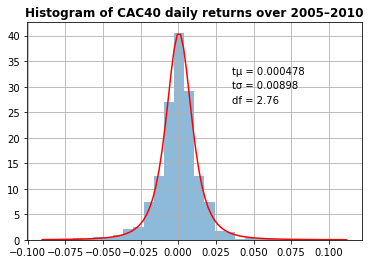

In [62]:
returns = dfna["CAC"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = numpy.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("CAC t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"tμ = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, u"tσ = {:.3}".format(tsigma))
plt.figtext(0.6, 0.6, u"df = {:.3}".format(tdf))
plt.title(u"Histogram of CAC40 daily returns over 2005–2010", weight='bold');

DAX t fit: mean=0.0008478030084081124, scale=0.008780828954086928, df=2.717669054363439


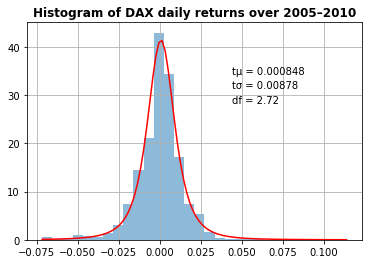

In [63]:
returns = dfna["DAX"]
returns.hist(bins=30, normed=True, histtype='stepfilled', alpha=0.5)
support = numpy.linspace(returns.min(), returns.max(), 100)
tdf, tmean, tsigma = scipy.stats.t.fit(returns.as_matrix())
print("DAX t fit: mean={}, scale={}, df={}".format(tmean, tsigma, tdf))
plt.plot(support, scipy.stats.t.pdf(support, loc=tmean, scale=tsigma, df=tdf), "r-")
plt.figtext(0.6, 0.7, u"tμ = {:.3}".format(tmean))
plt.figtext(0.6, 0.65, u"tσ = {:.3}".format(tsigma))
plt.figtext(0.6, 0.6, u"df = {:.3}".format(tdf))
plt.title(u"Histogram of DAX daily returns over 2005–2010", weight='bold');

Let's simulate random joint stock returns from a joint distribution of fitted-CAC and fitted-DAX according to the distribution parameters estimated above, and plot the results. We need these simulated joint returns to do a Monte Carlo VaR analysis of a stock portfolio composed of CAC and DAX stock.

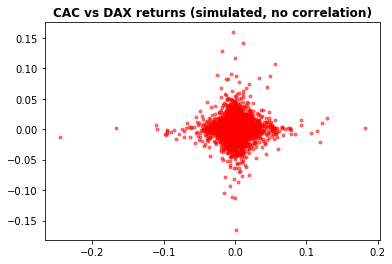

In [64]:
runs = 5000
fittedCAC = numpy.zeros(runs, float)
fittedDAX = numpy.zeros(runs, float)
for i in range(runs):
    fittedCAC[i] = scipy.stats.t.rvs(loc=0.000478137351981, scale=0.00898201242824, df=2.75557323986)
    fittedDAX[i] = scipy.stats.t.rvs(loc=0.000847802944791, scale=0.00878082895409, df=2.71766905436)
plt.plot(fittedCAC, fittedDAX, 'r.', alpha=0.5)
plt.title(u"CAC vs DAX returns (simulated, no correlation)", weight='bold');

**Problem**: our sampling from these fitted random variables doesn't match the observations from the real markets (scroll up to check the real CAC/DAX scatterplot). 

We need some way of generating a sample that respects the *correlation* between the input variables. All is revealed in the next episode on *Copula and multivariate dependencies*.